In [1]:
import numpy as np
import pandas as pd
from ast import literal_eval
from collections import Counter
import itertools
import tensorflow as tf
from tqdm import tqdm

Let's deal at first with Common Nouns Question Answering.

In [2]:
sample_train = pd.read_csv('data/CBT_CN_train.csv',delimiter=';')
sample_valid = pd.read_csv('data/CBT_CN_valid.csv',delimiter=';')

In [3]:
sample_train = sample_train.sample(n=40000, replace=True)

In [4]:
sample_train['Document'] = sample_train['Document'].apply(literal_eval)
sample_valid['Document'] = sample_valid['Document'].apply(literal_eval)
sample_train['Query'] = sample_train['Query'].apply(literal_eval)
sample_valid['Query'] = sample_valid['Query'].apply(literal_eval)
sample_train['Candidates'] = sample_train['Candidates'].apply(literal_eval)
sample_valid['Candidates'] = sample_valid['Candidates'].apply(literal_eval)

In [5]:
sample_train.head()

,Document,Query,Candidates,Answer
103638,"[a, false, fellow, ,, but, ,, in, his, fashion...","[the, xxxxx, i, gather, comes, into, england, ...","[gold, boat, bows, breath, chamber, coast, fas...",gold
37191,"[this, time, the, mother, said, now, that, i, ...","[when, the, three, witches, beheld, the, xxxxx...","[brother, chariot, minute, mother, proposal, s...",chariot
28288,"[what, shall, we, do, now, said, they, ., shal...","[the, next, day, ,, when, they, were, all, cut...","[blows, fairy, hand, horn, minds, purse, turn,...",purse
85895,"[we, should, have, been, feeling, very, comfor...","[i, do, n, t, know, where, you, expect, to, go...","[felicity, cause, girls, nothing, petitions, p...",felicity
64935,"[i, know, how, you, feel, jest, now, but, if, ...","[but, i, ll, find, her, sometime, ,, xxxxx, bl...","[god, mistress, channel, course, grace, lips, ...",mistress


In [6]:
sample_valid.head()

,Document,Query,Candidates,Answer
0,"[what, is, it, answered, he, ., the, ogre, is,...","[i, will, get, through, it, somehow, ,, if, i,...","[cousin, cloak, dog, maiden, mountain, needle,...",dog
1,"[then, they, said, to, the, little, girl, clim...","[the, lamia, ran, as, fast, as, she, could, af...","[illustration, children, eating, grazing, hare...",way
2,"[after, supper, mohammed, said, to, the, owner...","[if, she, has, ,, you, may, take, her, in, xxx...","[daughter, everybody, exchange, greyhound, han...",exchange
3,"[it, had, great, claws, as, big, as, ice, tong...","[he, went, over, to, the, xxxxx, and, looked, ...","[bed, boy, cheek, claws, face, might, monster,...",window
4,"[no, ,, it, looked, like, the, shadow, of, joh...","[peter, hopped, all, around, johnny, chuck, ,,...","[course, eyes, fat, feet, fellow, hand, sizes,...",eyes


### 1. Maximum frequency model.

In [7]:
# choose the candidate that has the maximum frequency in Query/Document
def maximum_frequency_prediction(row, use_Document_info=False):
    temp = row['Query']
    if use_Document_info:
        temp += row['Document']
    freqs = dict(Counter(temp))
    ans = row['Candidates'][0]
    for w in row['Candidates']:
        if w in freqs.keys() and (ans not in freqs.keys() or (freqs[w] > freqs[ans])):
            ans = w
    return ans

In [8]:
def max_freq_result(df, use_Document_info=False):
    accuracy = 0
    for _, row in df.iterrows():
        if maximum_frequency_prediction(row, use_Document_info) == row['Answer']:
            accuracy += 1
    print('\t Accuracy:', round(accuracy / df.shape[0], 2))

In [9]:
print('Maximum frequency (corpus):')
max_freq_result(sample_train, False)
print('Maximum frequency (corpus + context):')
max_freq_result(sample_train, True)

Maximum frequency (corpus):
	 Accuracy: 0.13
Maximum frequency (corpus + context):
	 Accuracy: 0.28


In the paper "THE GOLDILOCKS PRINCIPLE: READING CHILDREN’S BOOKS..." the results are $0.158$ with corpus-only and $0.281$ with corpus+context, which is pretty similar.

### 2. Embedding model.

We simultaneously learn input and output embedding matrices $I, O \in \mathbb{R}^{pxd}$, where $p$ is the embedding dimension and $d$ is the dictionary size.


For a given input passage $q$ and candidate word $c$ we compute score as:

$S(q,w) = (I\phi(q))^TO\phi(c)$, where $\phi(q)$ indicates one-hot representation of $q$.

In [10]:
def categorize_text(text, word_to_id, mapped_words):
    newtext = []
    text_to_process = text
    if type(text) is not list:
        text_to_process = [text]
    for word in text_to_process:
        if mapped_words is None or word in mapped_words:
            newtext.append(word_to_id[word])
        else:
            newtext.append(word_to_id['<NA>'])
    return newtext

def categorize_df(df, word_to_id=None):
    cat_df = pd.DataFrame(dtype=str).reindex_like(df)
    cat_df['Document'] = [[]] * len(df)
    cat_df['Query'] = [[]] * len(df)
    cat_df['Candidates'] = [[]] * len(df)
    cat_df['Answer'] = ['<NA>'] * len(df)
    words = []
    mapped_words = None
    id_to_word = None
    if word_to_id is None:
        print('Processing train data...')
        words += list(itertools.chain.from_iterable(df['Document'].values))
        words += list(itertools.chain.from_iterable(df['Query'].values))
        words += list(itertools.chain.from_iterable(df['Candidates'].values))
        words += list(df['Answer'].values)
        print('\t random word:', words[19374])
        words += ['<NA>']
        words = set(words)
        print('\t dictionary size(with NA):', len(words))
        word_to_id = {t: i for i, t in enumerate(words)}
        id_to_word = {i: t for i, t in enumerate(words)}
    else:
        print('Processing test data...')
        mapped_words = set(word_to_id.keys())
    
    cat_df['Document'] = df['Document'].apply(lambda row: categorize_text(row, word_to_id, mapped_words))
    cat_df['Query'] = df['Query'].apply(lambda row: categorize_text(row, word_to_id, mapped_words))
    cat_df['Candidates'] = df['Candidates'].apply(lambda row: categorize_text(row, word_to_id, mapped_words))
    cat_df['Answer'] = df['Answer'].apply(lambda row: categorize_text(row, word_to_id, mapped_words)[0])
    
    return cat_df, len(words), word_to_id, id_to_word

In [11]:
cat_train, dictionary_size, word_to_id, id_to_word = categorize_df(sample_train)

Processing train data...
	 random word: to
	 dictionary size(with NA): 40364


In [12]:
def check_categorization(id_to_word, df, cat_df, isTrain=True):
    print('Checking categorization...')
    ind_s = np.random.randint(0, high=len(df), size=100)
    allClear = True
    NA_freq = 0
    tot_len = 0
    for i in ind_s:
        for col in df.columns[:-1]:
            temp = cat_df[col].iloc[i]
            assert type(temp) is list
            tot_len += len(temp)
            for j in range(len(temp)):
                if id_to_word[temp[j]] != df[col].iloc[i][j]:
                    if isTrain or id_to_word[temp[j]] != '<NA>':
                        allClear = False
                    else:
                        NA_freq += 1
        tot_len += 1
        if id_to_word[cat_df['Answer'].iloc[i]] != df['Answer'].iloc[i]:
            if isTrain or id_to_word[cat_df['Answer'].iloc[i]] != '<NA>':
                allClear = False
            else:
                NA_freq += 1
    NA_freq = 100.0 * float(NA_freq) / float(tot_len)
    if allClear:
        print('\t Sector is clear')
        if NA_freq > 0:
            print('\t Percentage of <NA> words:', NA_freq)
    else:
        print('\t ... Not clear! Not clear!')

In [13]:
check_categorization(id_to_word, sample_train, cat_train)

Checking categorization...
	 Sector is clear


In [14]:
cat_valid, _, _, _ = categorize_df(sample_valid, word_to_id)

Processing test data...


In [15]:
check_categorization(id_to_word, sample_valid, cat_valid, isTrain=False)

Checking categorization...
	 Sector is clear
	 Percentage of <NA> words: 0.7360082881871749


In [16]:
def sample_batch(data, batch_size, word_to_id):
    inds = np.random.randint(0, len(data), size=batch_size)
    X = []
    for arr in data.iloc[inds]['Query'].values:
        i = np.where(np.array(arr) == word_to_id['xxxxx'])[0][0]
        d1 = i
        d2 = len(arr) - 1 - i
        if d1 > 4 and d2 > 4:
            X += [arr[i-5:i] + arr[i+1:i+6]]
        elif d1 > 4:
            X += [arr[i-5:i] + arr[i+1:len(arr)] + [word_to_id['<NA>']]*(5-d2)]
        elif d2 > 4:
            X += [[word_to_id['<NA>']]*(5-d1) + arr[0:i] + arr[i+1:i+6]]
    X = np.array(X)
    C, y = [], []
    for i in inds:
        arr = data.iloc[i]['Candidates']
        C += [list(arr)]
        y += [list(np.array(arr == data.iloc[i]['Answer'],dtype=int))]
    C = np.array(C)
    y = np.array(y)
    return X, C, y, inds

In [17]:
X_ex, C_ex, y_ex, ind_ex = sample_batch(cat_train, 3, word_to_id)

In [18]:
X_ex, y_ex

(array([[38630, 34073, 25340, 21536, 21989, 30500,  3175, 34073,  2598,
         21536],
        [ 6930, 29726, 32199,  5679, 21536, 12626, 13359, 31525, 34073,
         25043],
        [ 7903,  7903,  7903,  7903, 21536, 31260, 21536, 23028, 36960,
          8000]]), array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]))

In [19]:
embedding_size = 30
tf.reset_default_graph()
X = tf.placeholder(tf.int32, [None, 10], name='input_passage')
C = tf.placeholder(tf.int32, [None, 10], name='candidates')
y = tf.placeholder(tf.int32, [None, 10], name='answers')

input_embeddings = tf.Variable(tf.random_uniform([dictionary_size, embedding_size], 0, 0.1, dtype=tf.float32))
output_embeddings = tf.Variable(tf.random_uniform([dictionary_size, embedding_size], 0, 0.1, dtype=tf.float32))

emb_X = tf.nn.embedding_lookup(input_embeddings, X)
emb_X = tf.reduce_sum(emb_X, axis=1)
print(emb_X.shape)
emb_C = tf.nn.embedding_lookup(output_embeddings, C)
print(emb_C.shape)

scores = tf.reduce_sum(tf.tensordot(emb_C, emb_X, axes=[2, 1]), axis=2)
logits = tf.nn.softmax(scores)
print(logits.shape)

loss = tf.losses.log_loss(labels=y, predictions=logits)

equality = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
num_equals = tf.reduce_sum(tf.cast(equality, tf.float32))
#accuracy, _ = tf.metrics.accuracy(labels=tf.argmax(y,1), predictions=tf.argmax(logits,1))

train_op = tf.train.AdamOptimizer().minimize(loss, )

(?, 30)
(?, 10, 30)
(?, 10)


In [20]:
s = tf.Session()
s.run(tf.global_variables_initializer())

n_epochs = 100
batches_per_epoch = 100
batch_size = 64

train_losses = []
valid_losses = []
accuracies = []

for epoch in tqdm(range(n_epochs)):
    #old_test_loss = avg_test_loss
    avg_train_loss, avg_valid_loss = 0, 0
    avg_acc = 0
    for batch in range(batches_per_epoch):
        x_, c_, y_, inds_ = sample_batch(cat_train, batch_size, word_to_id)

        _, iloss, y_pred, acc = s.run([train_op, loss, logits, num_equals], {X: x_,
                                                                 C: c_,
                                                                 y: y_})
        avg_train_loss += iloss
        avg_acc += acc
        x_valid, c_valid, y_valid, _ = sample_batch(cat_valid, batch_size, word_to_id)
        
        iloss, acc = s.run([loss, num_equals], {X: x_valid, C: c_valid, y: y_valid})
        avg_valid_loss += iloss
        avg_acc += acc
    #print("EPOCH: ", epoch)
    #print("\t AVERAGE TRAIN LOSS:", avg_train_loss/batches_per_epoch)
    #print("\t AVERAGE VALID LOSS:", avg_valid_loss/batches_per_epoch)
    #print('\t AVERAGE ACCURACY:', avg_acc/batches_per_epoch)
    train_losses.append([avg_train_loss/batches_per_epoch])
    valid_losses.append([avg_valid_loss/batches_per_epoch])
    accuracies.append([avg_acc/(batches_per_epoch * batch_size * 2)])
    #if epoch != 0 and avg_test_loss > old_test_loss:
    #    pass
        #print('problems...')
total_num_of_examples = n_epochs * batches_per_epoch * batch_size * 2
total_accuracy = np.sum(accuracies) * batches_per_epoch * batch_size * 2 / total_num_of_examples
print('Average accuracy is', total_accuracy)

100%|██████████| 100/100 [09:39<00:00,  5.79s/it]

Average accuracy is 0.2691125


In [21]:
from matplotlib import pyplot as plt

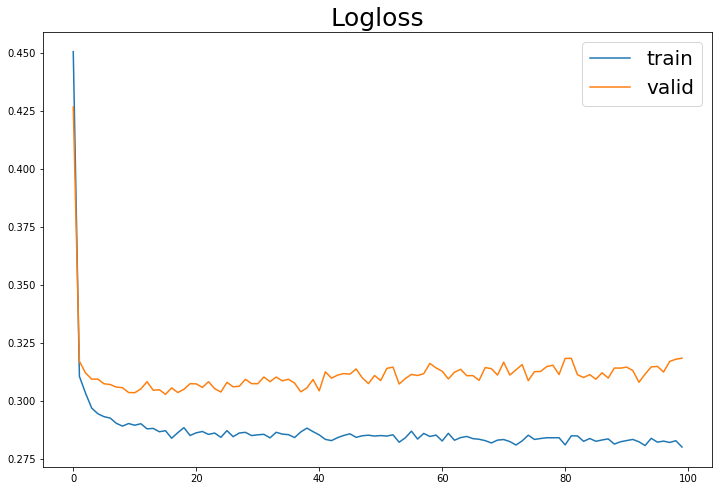

In [24]:
plt.figure(figsize=(12,8))
plt.title('Logloss', size=25)
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend(loc='best',fontsize=20)
plt.show()

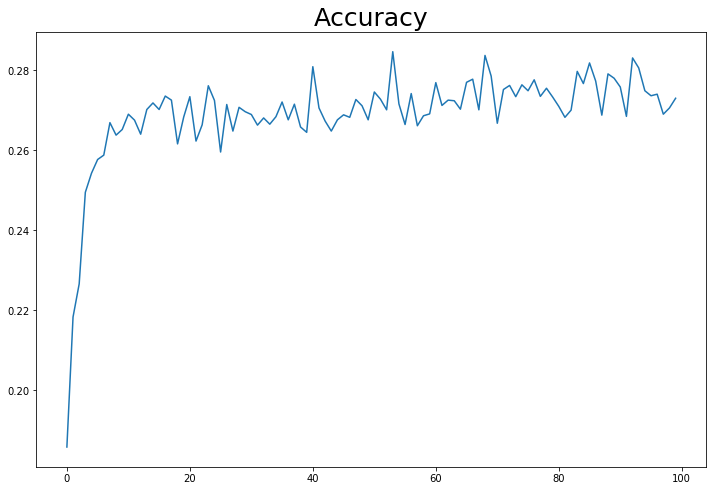

In [25]:
plt.figure(figsize=(12,8))
plt.title('Accuracy', size=25)
plt.plot(accuracies)
plt.show()

In [26]:
np.max(accuracies)

0.28468749999999998